# VOBHS 

A template framework for collecting all the OHLC data for cryptocurrencies from Binance and other crypto exchanges

Use the "Run" button to execute the code.

In [1]:
!pip install jovian ccxt pyti telepot schedule --upgrade --quiet

In [2]:
import ccxt
import jovian
import requests
import math
import datetime
import concurrent
import os
import glob
import telepot
import schedule
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

from pyti.hull_moving_average import hull_moving_average as hull_moving_average
from pyti.average_true_range import average_true_range as average_true_range

In [3]:
#telegram vobhs channel
token ='5548070657:AAHC7F16LoJkQ4OuPNKrRdGxR59UzFv61bc'
receiver_id = -1001664185149

bot = telepot.Bot(token)

signal_dir = 'signals'
if not os.path.exists(signal_dir):
    os.mkdir(signal_dir)

outdir = 'tickers'
if not os.path.exists(outdir):
    os.mkdir(outdir)

try:
    
    symbols_url = "https://fapi.binance.com/fapi/v1/ticker/price"
    symbols_data = requests.get(symbols_url).json()
    symbols_df = pd.DataFrame(symbols_data)
    symbols_df = symbols_df[symbols_df["symbol"].str.contains("USDT")]
    symbols = list(symbols_df["symbol"])
    # some ends with numbers(eg:Quarterly Contracts), hence filter:
    symbols = list(filter(lambda x: x.endswith(("USDT")), symbols))
except ValueError:
    symbols = pd.read_csv('symbols.csv', index_col=False)
    symbols = futures_tickers_binance['0'].to_list()


    
#df to image
def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=10,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [4]:
def calculate_vobhs(symbol, interval):
    
    binance = ccxt.binanceusdm({'options': {'enableRateLimit': True}})
    symbol = symbol
    interval = interval
    
    df = pd.DataFrame(binance.fetch_ohlcv( symbol, interval, limit=1000))
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], unit='ms') + pd.Timedelta(hours=2)
    df['Symbol'] = symbol


    atr_multiplier = 2.5
    df['atr'] = average_true_range(df['Close'],3)
    df['sell_stop_loss'] = (df['Close'] + df['atr'] * atr_multiplier) #atr_upper_band
    df['buy_stop_loss'] = (df['Close'] - df['atr'] * atr_multiplier) #atr_lower_band


    #Hull MA
    df['m_hull'] = hull_moving_average(df['Close'], 400) #length premultiplied by 2
    df['s_hull'] = df['m_hull'].shift(2)

    #hull color
    df['m_s_above'] = df['m_hull'] > df['s_hull']
    df['hull_color_status'] = df.apply(lambda x: 'green' if x.m_s_above == True else 'red', axis =1)

    #hull price
    df['price_above'] = (df['Close'] > df['s_hull']) & (df['Close'] > df['m_hull'])
    df['hull_price_status'] = df.apply(lambda x: 'above' if x.price_above == True else 'below', axis =1)

    df = df.drop(['m_s_above','price_above'],axis=1)


    #Volatility Oscillator
    length  = 100
    df['spike'] = df['Close'] - df['Open']
    df['x'] = df['spike'].rolling(length).std()
    df['y'] = df['x'] * -1

    df['above'] = df['spike'] > df['x']
    df['below'] = df['spike'] < df['y']

    df['vo_status'] =  df.apply(lambda x: 'above' if x.above == True 
                                 else ('below' if x.below == True 
                                 else 'between'), axis =1)

    df = df.drop(['High','Low','above','below'], axis=1)
    df['vo_status'] =df['vo_status'].shift(-1)


    #Boom-Pro Indicator

    #Input Close values to return HP
    def high_pass_filter(data):
        PI = np.pi
        HP = []

        for i, _ in enumerate(data):
            if i < 2:
                HP.append(0)
            else:
                angle = 0.707 * 2 * PI/100
                alpha1 = (math.cos(angle) + math.sin(angle)-1)/ math.cos(angle)
                HP.append(math.pow(1.0-alpha1/2.0, 2)*(data[i]-2*data[i-1]+data[i-2]) + 2*(1-alpha1)*HP[i-1] - math.pow(1-alpha1, 2)*HP[i-2])

        return HP

    #Input HP to smoothen and return Filt 
    def super_smoother(data, LPPeriod):
        Filt = []
        for i, _ in enumerate(data):
            if i < 2:
                Filt.append(0)
            else:
                arg = 1.414 * 3.14159 / LPPeriod
                a_1 = math.exp(-arg)
                b_1 = 2 * a_1 * math.cos(4.44/float(LPPeriod))
                c_2 = b_1
                c_3 = -a_1 * a_1
                c_1 = 1 - c_2 - c_3
                Filt.append(c_1 * (data[i] + data[i-1]) / 2 + c_2 * Filt[i-1] + c_3 * Filt[i-2])
        return Filt

    #Input Filt values to return X
    def agc(data):
        X = []
        Peak = []
        for i, _ in enumerate(data):
            if i < 1:
                X.append(0)
                Peak.append(0)
                #Peak.append(.0000001)
            else:
                Peak.append(0.991 * Peak[i - 1])
                if abs(data[i]) > Peak[i]:
                    Peak[i] = abs(data[i])

                if Peak[i] != 0:
                    X.append(data[i] / Peak[i])

        return X

    #Input X to return final Quotient 
    def quotient(data, K_val):
        K = K_val
        Q = []
        for i, _ in enumerate(data):
            if i<1:
                Q.append(0)
            else:
                Q.append((data[i]+ K) / (K*data[i]+1))
        return Q

    #Input Quotient to return smoothen the quotient
    def sma(data, length):
        trigger = []
        for i, _ in reversed(list(enumerate(data))):
            sum = 0
            for t in range(i - length + 1, i + 1):
                sum = sum + data[t] / length
            trigger.insert(0, sum)
        return trigger

    K1 = 0
    K2 = 0.4
    LPPeriod_1 = 6
    LPPeriod_2 = 27

    HP = high_pass_filter(df.Close)

    #quotient 1 params
    Filt_1 = super_smoother(HP, LPPeriod_1)
    X_1 = agc(Filt_1)

    #quotient 2 params
    Filt_2 = super_smoother(HP, LPPeriod_2)
    X_2 = agc(Filt_2)

    df = df.reset_index()
    q1 = quotient(X_1, K1)
    q2 = quotient(X_2, K2)

    trig = sma(q1,length=2)
    df['trig'] = pd.Series(trig)

    df['white_line'] = df['trig']
    df['red_line'] = pd.Series(q2)

    df['white_line'] = (df['white_line']*100)+110
    df['red_line'] = (df['red_line']*100)+110


    df['prev_white_line'] = df['white_line']
    df['prev_white_line'] = df['prev_white_line'].shift(1)

    df['prev_red_line'] = df['red_line']
    df['prev_red_line'] = df['prev_red_line'].shift(1)

    df = df.fillna(method='ffill')
    df.dropna(inplace=True)

    df['bullish_cross'] = (df['prev_white_line'] < df['red_line']) & (df['white_line'] > df['red_line']) & (df['white_line']<85)

    df['bearish_cross'] = (df['prev_red_line'] < df['white_line']) & (df['red_line'] > df['white_line']) & (df['red_line']>15)
    df['crossover'] = df.apply(lambda x: 'bullish crossover' if x.bullish_cross == True
                          else ('bearish crossover' if x.bearish_cross == True else 'none'), axis=1)
    df = df.drop(['bullish_cross','bearish_cross'], axis=1)

    df = df[df.columns.drop(list(df.filter(regex='index')))]


    df['buy'] = (df['crossover']=='bullish crossover') & (df['hull_color_status']=='green') & (df['hull_price_status']=='above') & (df['vo_status']=='above')
    df['sell'] = (df['crossover']=='bearish crossover') & (df['hull_color_status']=='red') & (df['hull_price_status']=='below') & (df['vo_status']=='below')

    df['signal'] = df.apply(lambda x: 'buy' if x.buy == True
                              else ('sell' if x.sell == True else 'none'), axis=1)

    buy_signal = df[df['signal']=='buy'].copy()
    sell_signal = df[df['signal']=='sell'].copy()

    signal_df = sell_signal.append(buy_signal).sort_index()
    signal_df.to_csv(f"signals/"+symbol+'signal.csv')
    return

In [5]:
def run_vobhs():
        
    with concurrent.futures.ProcessPoolExecutor() as executor:
        execution_1 = [executor.submit(calculate_vobhs,symbol,interval='5m') 
                for symbol in symbols]
    return

In [6]:
def find_signals():
    
    files = os.path.join("signals/", "*.csv")
    files = glob.glob(files)

    df = pd.concat(map(pd.read_csv, files), ignore_index=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop(['Unnamed: 0'], axis =1)
    df = df.sort_values(by='Date',ascending=True)
    df['Date'] = df['Date'] #+ pd.Timedelta(hours=2)

    df = df.drop(['Open', 'Close',
            'Volume', 'atr',
            'spike', 'x', 'y', 'vo_status', 'm_hull',
            's_hull','trig', 'white_line', 'red_line', 'prev_white_line',
            'prev_red_line', 'buy', 'sell'], axis=1)

    df = df.set_index('Date')
    df = df.tail(10)
    current_time = datetime.datetime.now()
    current_day = current_time.day
    current_time = current_time.hour +2 #Berlin CET
    df_signal = df[df.index.day == (current_day)]
    df_signal = df_signal[df_signal.index.hour >= (current_time-2)]
    return df_signal

In [7]:
def execute_vobhs():
    run_vobhs()
    df_signal = find_signals()
    
    if df_signal.empty:

        pass
    else:
        df_image = df_signal.reset_index()
        df_compare = pd.read_csv('compare.csv')
        df_compare['Date'] = pd.to_datetime(df_compare['Date'])

        if df_image.tail(1).equals(df_compare.tail(1)):
            pass
        else:
            df_image.to_csv('compare.csv', index=False)
            df_image['sell_stop_loss'] = df_image['sell_stop_loss'].round(decimals=4)
            df_image['buy_stop_loss'] = df_image['buy_stop_loss'].round(decimals=4)
            df_image = df_image.drop(['hull_color_status','hull_price_status','crossover'], axis=1)
            df_image =df_image.rename(columns = {'Date':'Date UTC+2 '})

            fig,ax = render_mpl_table(df_image, header_columns=0, col_width=2.0)
            fig.savefig("df_image.png")
            bot.sendPhoto(receiver_id, photo=open('df_image.png','rb'))
    
    return df_signal


In [9]:
#Initializing a dummy csv data for compare on 1st run
run_vobhs()
df_compare = pd.read_csv('signals/BTCUSDTsignal.csv')
df_compare.to_csv('compare.csv')

,Symbol,sell_stop_loss,buy_stop_loss,hull_color_status,hull_price_status,crossover,signal
Date,,,,,,,
2022-08-06 07:20:00,ENJUSDT,0.694002,0.681398,red,below,bearish crossover,sell
2022-08-06 08:25:00,MATICUSDT,0.928423,0.922777,green,above,bullish crossover,buy


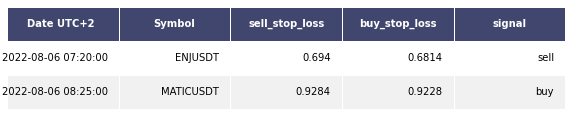

In [10]:
execute_vobhs()

In [11]:
pd.read_csv('signals/BTCUSDTsignal.csv')

,Unnamed: 0,Date,Open,Close,Volume,Symbol,atr,sell_stop_loss,buy_stop_loss,m_hull,...,vo_status,trig,white_line,red_line,prev_white_line,prev_red_line,crossover,buy,sell,signal
0,693,2022-08-05 07:45:00,23077.6,23145.2,2816.727,BTCUSDT,38.341728,23241.05432,23049.34568,22753.836668,...,above,-0.458497,64.15033,49.085754,38.406219,47.502213,bullish crossover,True,False,buy


In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="ohlc-multi-asset")

<IPython.core.display.Javascript object>

In [ ]:
schedule.every(3).minutes.do(execute_vobhs)

while 1:
    schedule.run_pending()
    time.sleep(1)